### If this is your first encounter with ELFI, we recommend that you start with the ELFI_tutorial notebook.

# Automatic parallelization with ipyparallel

Behind the scenes, ELFI can automatically parallelize the computational inference via clients that support it. Currently ELFI has two clients:

- `elfi.clients.native` (activated by default): does not parallelize but makes it easy to test and debug your code.
- `elfi.clients.ipyparallel`: [_ipyparallel_](http://ipyparallel.readthedocs.io/) based client can parallelize both locally (using available cores) and in a distributed cluster.

We will show in this notebook how to activate and use the `ipyparallel` client.


### Turn on parallelization

To activate the `ipyparallel` client in ELFI just import it with `import elfi.clients.ipyparallel`. Before you can actually run things in parallel you also need to start an `ipyparallel` cluster. Below is an example of how to start a local cluster using your CPU cores (tested in a Unix-like operating system). Please see the [ipyparallel documentation](http://ipyparallel.readthedocs.io/en/latest/intro.html) for more info and details for setting up ipyparallel clusters.

### Tuning the parallelization

The parallelization performance can be tuned with the keyword argument `batch_size` given for the inference methods (e.g. Rejection). Batch size tells how many "runs" (evaluations of the generative model) each available worker should run before sending back the results. Because of overhead involved in parallelization, batches should be large enough in computation time, but not too large in memory consumption eating all of your memory. The simulator node often outputs the largest amount of data, so you should count that at least twice the amount of output data in a batch from the simulator should easily fit into the memory. (Also remember that in a shared-memory system this precious resource is shared among the workers). 

**Note:** this notebook demonstrates parallelization with the rejection sampling ABC algorithm, which is an example of [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) computing: each simulation is completely independent. Such algorithms highly benefit from parallelization. Some other algorithms depend heavily on previous results making them much harder to parallelize in a meaningful way.

**Note:** Even when using the default native client, Numpy may use multiple cores in its operations as well.

### Starting ipcluster

Taking advantage of ipyparallel requires that you have an Ipyparallel cluster running. You can start a local cluster with the following command (the exclamation mark is a Jupyter syntax for executing shell commands):

In [1]:
!ipcluster start -n 4 --daemon

This starts 1 Ipyparallel controller and 4 engines (workers) on a single host. The `daemon` option makes Ipyparallel run in the background, which is necessary in the notebook environment. This however means that one should remember to `stop` the ipcluster once it's no longer needed (see [bottom](#Remember-to-stop-the-ipcluster-when-done) of this notebook). 

One may also run the command in a separate terminal window, which is beneficial for debugging. For more options and details on Ipyparallel, please see its [documentation](http://ipyparallel.readthedocs.io).

In [2]:
# This is here just to ensure that ipcluster has started properly before continuing
import time
time.sleep(10)

### Parallel inference with ELFI

Now we can proceed to importing ELFI. It is important that all imports and definitions are visible to all Ipyparallel engines, which may be less trivial in some distributed environments. Here it suffices that *ELFI has been installed*, or added to the `PYTHONPATH`.

In [3]:
import elfi

ELFI is told to use the ipyparallel cluster by importing the client:

In [4]:
import elfi.clients.ipyparallel

The MA2 model described and built in the basic ELFI tutorial is available for importing under `elfi.examples`:

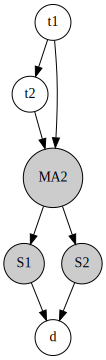

In [5]:
from elfi.examples import ma2
model = ma2.get_model()

elfi.draw(model)

Otherwise everything should be familiar, and ELFI handles everything for you regarding the parallelization. 

In [6]:
rej = elfi.Rejection(model, 'd', batch_size=10000)

When running the next command, take a look at the system monitor of your operating system; it should show 4 (or whatever number you gave the `ipcluster start` command) Python processes doing heavy computation simultaneously.

In [7]:
%time result = rej.sample(5000, n_sim=int(5e6))  # 5 million simulations

CPU times: user 3.03 s, sys: 180 ms, total: 3.21 s
Wall time: 14.2 s


The `Result` object is also just like in the basic case:

In [8]:
result.summary

Method: Rejection
Number of posterior samples: 5000
Number of simulations: 5000000
Threshold: 0.0358
Posterior means: t1: 0.655, t2: 0.159


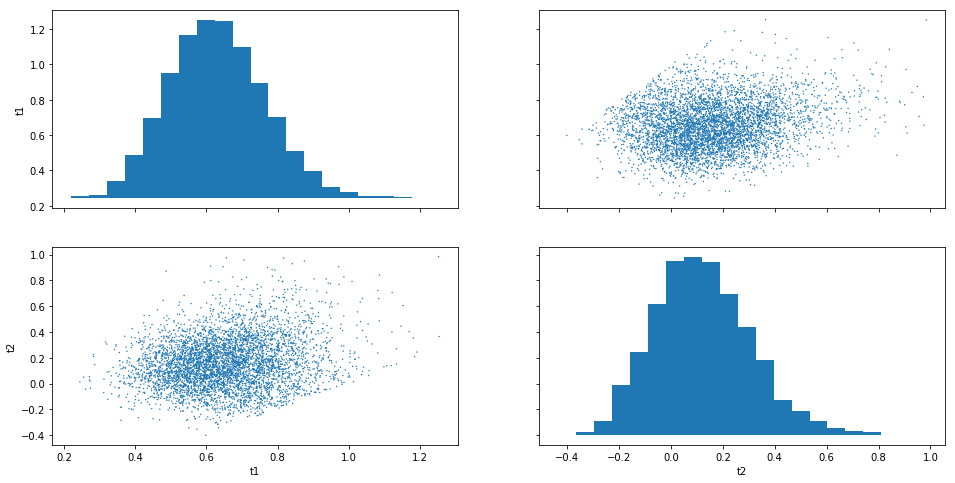

In [9]:
import matplotlib.pyplot as plt
result.plot_pairs()
plt.show()

To summarize, the only thing that needed to be changed from the basic scenario was enabling the `ipyparallel` client.

### Functions in Jupyter and Ipyparallel

All imports and definitions must be visible for all Ipyparallel engines. This means that customizing the model from within the notebook has some caveats.

You can change the model with built-in functionality like this without problems:

In [10]:
d2 = elfi.Distance('cityblock', model['S1'], model['S2'], p=1)

rej2 = elfi.Rejection(d2, batch_size=10000)
result2 = rej2.sample(1000, quantile=0.01)

But let's say you want to use your very own distance:

In [11]:
def my_distance(x, y):
    # Note that interactively defined functions must use full module names, e.g. numpy instead of np
    return numpy.sum((x-y)**2, axis=1)

d3 = elfi.Distance(my_distance, model['S1'], model['S2'])
rej3 = elfi.Rejection(d3, batch_size=10000)

This is not automatically visible for the ipyparallel engines, the below will therefore fail:

In [12]:
# This will fail if you try it!
# result3 = rej3.sample(1000, quantile=0.01)

Ipyparallel provides a way to manually `push` the new definition to the scopes of the engines. Because `my_distance` also uses numpy, that must be imported in the engines as well:

In [13]:
# Get the ipyparallel client
ipyclient = elfi.get_client().ipp_client

# Import numpy in the engines (note that you cannot use "as" abbreviations, but must use plain imports)
with ipyclient[:].sync_imports():
    import numpy

# Then push my_distance to the engines
ipyclient[:].push({'my_distance': my_distance})


importing numpy on engine(s)


<AsyncResult: _push>

The above may look a bit cumbersome, but now this works:

In [14]:
rej3.sample(1000, quantile=0.01)  # now this works

Method: Rejection
Number of posterior samples: 1000
Number of simulations: 100000
Threshold: 0.013
Posterior means: t1: 0.654, t2: 0.163

However, a simple solution to problems like this is to define your functions in external scripts (see `elfi.examples.ma2`) and have the module files be available in the folder where you run your ipyparallel engines.

### Remember to stop the ipcluster when done

In [15]:
!ipcluster stop

2017-05-19 17:09:08.430 [IPClusterStop] Stopping cluster [pid=2398185] with [signal=<Signals.SIGINT: 2>]
